In [1]:
# Import the necessary components
from epydemix import EpiModel, simulate
from epydemix.visualization import plot_quantiles

# Defining a basic SIR model
sir_model = EpiModel(
    name='SIR Model',
    compartments=['S', 'I', 'R'],  # Susceptible, Infected, Recovered
    parameters={
        'beta': 0.3,  # Transmission rate
        'gamma': 0.1  # Recovery rate
    }
)

# Defining the transitions
sir_model.add_transition(source='S', target='I', rate='beta', agent='I')
sir_model.add_transition(source='I', target='R', rate='gamma')

# Initial conditions
initial_conditions = {
    'S': 100000-10,  
    'I': 10,   
    'R': 0     
}

# running the simulations


In [2]:
def run_sir(): 
    trajectory = simulate(sir_model,
        start_date="2024-01-01",
        end_date="2024-04-10")

    return trajectory  

In [4]:
%timeit run_sir()   

23.6 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


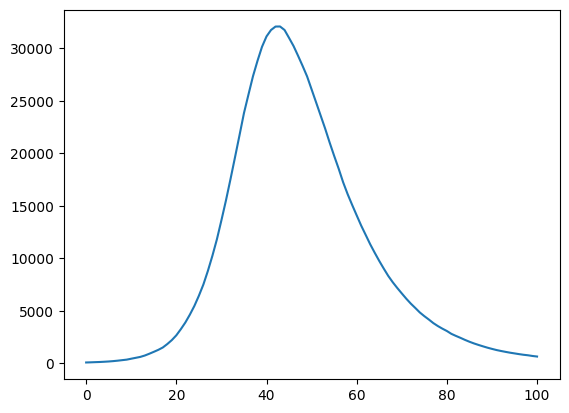

In [5]:
res = run_sir()
import matplotlib.pyplot as plt 
plt.plot(res.data["I_total"])


In [6]:
len(res.data["I_total"])

101

In [7]:
len(res.dates)

101

In [ ]:
plot_quantiles(res, columns=["I_total", "S_total", "R_total"], title='SIR Model Simulation')

In [2]:
trajectory = simulate(sir_model,
        start_date="2024-01-01",
        end_date="2024-04-10")


In [8]:
simulations = sir_model.run_simulations(
    start_date="2024-01-01",
    end_date="2024-04-10")


In [ ]:
simulations.get_quantiles()